# Báo cáo đồ án
Môn: Lập trình song song ứng dụng
MSSS | Họ và tên
| ---- | ---- |
| 21120449 | Nguyễn Văn Hậu |
| 21120464 | Nguyễn Quốc Hưng |  

[GitHub](https://github.com/NguyenQuocHung47/APP)
## Chủ đề: Image Sharpening

## I. Mô tả

### 1. Tổng quan
Trong xử lý ảnh, image sharpening giúp làm nổi bật chi tiết, cải thiện độ rõ nét của các đối tượng và biên trong ảnh. Tuy nhiên, các phương pháp làm sắc nét truyền thống như **Unsharp Masking** có thể gây ra hiệu ứng **halo**, làm xuất hiện các viền sáng/tối không tự nhiên quanh biên ảnh. Để khắc phục vấn đề này, chúng ta cần áp dụng các kỹ thuật phức tạp hơn bảo toàn chi tiết mà không gây nhiễu.  
Đâu vào : Ảnh định dạng jpg  
Đầu ra : Ảnh được tăng cường độ sắc nét

![output.png](attachment:output.png)

## 2. Chi tiết  
Phương pháp: sử dụng kết hợp Gaussian Blur và [High-Frequency Detail-Preserving Contrast Enhancement](https://www.semanticscholar.org/reader/3b7a0d22d805d3671b8412aaf62d955d44d02c5b)    
**High-Frequency Detail-Preserving Contrast Enhancement** được tham khảo từ bài nghiên cứu [An Efficient and Self-Adapted Approach to
the Sharpening of Color Images](https://www.semanticscholar.org/reader/3b7a0d22d805d3671b8412aaf62d955d44d02c5b)- Lih-Jen Kau,Tien-Lin Lee, được xuất bản trên tạp chí The Scientific World Journal năm 2013, đề xuất một phương pháp làm sắc nét ảnh màu hiệu quả và tự thích ứng. Phương pháp này tập trung vào việc tăng cường độ sắc nét của ảnh màu trong khi vẫn bảo toàn các chi tiết quan trọng và không gây ra hiệu ứng halo, chỉ sử dụng kênh Value để làm sắc nét ảnh.  

![image.png](attachment:image.png)  





### Các bước thực hiện

- Chuyển đổi RGB -> HSV
- Gaussian Blur
- Edge Detection cho kênh Value
- Low-pass Filtering
- Tính toán additive magnitude  
- Edge sharpen  
- Chuyển đổi HSV -> RGB

### Phân tích thuật toán
**1. Chuyển đổi RGB -> HSV**   
Ban đầu, hình ảnh  được biểu diễn bằng định dạng màu RGB. Do đó phải chuyển đổi sang không gian màu HSV để thực hiện quá trình làm sắc nét hình ảnh.  
Trước khi chuyển đổi, 3 thành phần RGB sẽ được chuẩn hóa về [0,1].  
Mỗi pixel của ảnh RGB được chuyển sang không gian màu HSV bằng công thức:  
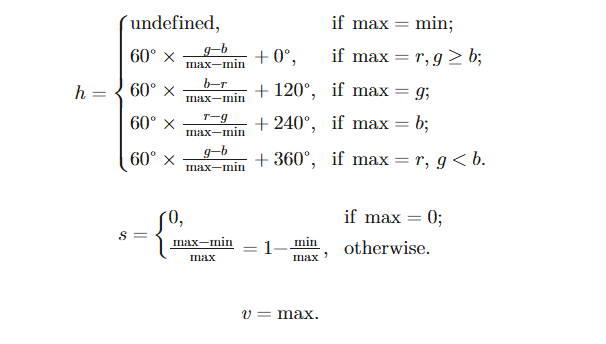


**2. Gaussian Blur**  
Giảm nhiễu trong ảnh trước khi thực hiện phát hiện biên.  
Làm mượt các vùng có biến đổi nhẹ để tránh phát hiện sai biên do nhiễu.  
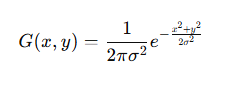

![image.png](attachment:image.png)

**3. Edge Detection**  
Xác định các khu vực có sự thay đổi mạnh về cường độ sáng (biên của vật thể).  
Sử dụng trên kênh V (Value) trong không gian màu HSV.  

chúng ta xác định xem mỗi pixel có phải là cạnh hay không bằng cách kiểm tra các lân cận trên và trái. Nếu một trong 2 lân cận của nó có sự khác biệt vượt quá ngưỡng nhất định, pixel này là biên.  
Giá trị **eth** được đề nghị là [8,18] -> [0.08,0.18]  
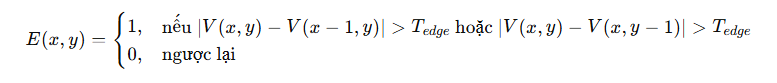



Đầu vào là một hình ảnh HSV và đầu ra là một hình ảnh biên 0-1 chỉ có 1 giá trị. Giá trị 1 trong đầu ra cho biết pixel là một biên.

![edges_detected0.jpg](attachment:edges_detected0.jpg)

*Kết quả trả về với **eth** = 0.07*

**4. Low-pass filtering**  
Tiếp tục làm việc trên ảnh cạnh từ giai đoạn trước và sử dụng **Low-pass filtering** lọc ra các pixel cạnh bị cô lập. Đối với mỗi pixel đã được đánh dấu là cạnh, đếm số lượng 8 lân cận. Nếu số đếm nhỏ hơn ngưỡng nhất định, pixel này sẽ được đánh dấu là không phải cạnh.  
Giá trị threshold nằm trong khoảng [0;8]  
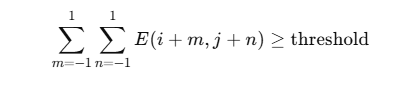


![edges_detected.jpg](attachment:edges_detected.jpg)  
*Kết quả sau khi sử dụng LPF với **threshold**=2*

**5. Tính toán độ lớn cộng gộp (?) - additive magnitude**  
Xác định độ lớn cộng gộp tối đa - maximum additive magnitude. Tính bằng giá trị tối đa, tối thiểu và trung bình trên toàn bộ hình ảnh HSV.  
Trong quá trình làm sắc nét ảnh sử dụng kênh Value, để tăng kết quả làm sắc nét, ta sử dụng 1 độ lớn cộng gộp để điều chỉnh giá trị pixel trên biên. Tuy nhiên, điều này có thể dẫn đến sự bão hòa cường độ - saturation of intensity ( khi V tăng vượt quá giới hạn tối đa (1.0), tức là nó sẽ đạt độ sáng tối đa có thể, mất chi tiết và có thể tạo ra hiện tượng "cháy sáng" (overexposure) trong ảnh).
Với mục tiêu độ lớn cộng gộp phù hợp với từng ảnh cụ thể (Sefl-Adapted), tác giả sử dụng thống kê toàn cục (global statistics) của kênh V để tính delta.  
Dựa trên thực nghiệm, tác giả nhận thấy rằng:
-   Một mức tăng/giảm khoảng Max/8 tại các vùng biên là đủ để tạo ra sự khác biệt nhận thấy được bằng mắt người.

-   Với ảnh có độ sáng cao, cần một độ tăng cường nhỉnh hơn Max/8 để làm sắc nét rõ ràng.

-   Ngược lại, ảnh tối chỉ cần ít hơn Max/8 là đủ.

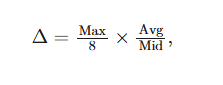

**6. Làm sắc nét dựa trên biên**  

Ở bước này, cường độ của các điểm ảnh nằm xung quanh vùng biên được điều chỉnh thông qua một giá trị tăng hoặc giảm nhằm làm nổi bật biên ảnh (edge). Trong khi đó, các điểm ảnh không thuộc vùng biên sẽ giữ nguyên giá trị, nhằm tránh gây nhiễu và đảm bảo các chi tiết ảnh cho các vùng khác của ảnh.

Để làm nổi bật cả những biên có độ chênh lệch nhỏ mà không gây ra hiện tượng làm sắc nét quá mức (oversharpening), giá trị điều chỉnh $\delta_x$ cần được điều chỉnh linh hoạt dựa trên thống kê cục bộ của ảnh thay vì chỉ dựa vào thống kê toàn cục  


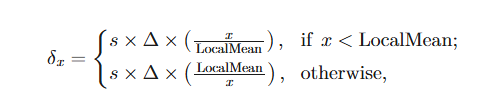


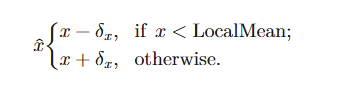

**7. Chuyển đổi HSV -> RGB**


## II. Câu hỏi hàng tuần

####  Tuần 1

**Q1:** Tại sao khi chuyển đổi RGB -> HSV, h = underfined nếu max = min?

**Answer:** Khi chuyển đổi RGB -> HSV, nếu ba thành phần R, G và B tại một điểm ảnh bằng nhau, ta có max = min.
Khi đó, ảnh tại điểm đó là màu xám trung tính và không biểu hiện một tông màu cụ thể nào.
Điều này làm cho thành phần H trở nên không xác định về mặt toán học, do công thức tính H có chứa phép chia cho (max - min), vốn sẽ bằng 0 trong trường hợp này -> H tại những điểm ảnh có màu xám = undefined

**Q2:** Kế hoạch của nhóm sẽ song song hóa nó nhanh gấp bao nhiêu lần so với cài đặt tuần tự?

**Answer:** Tối thiểu 5x

**Q3:** Sự khác biệt giữa Image Sharpening và Image Smoothing là gì?

**Answer:**
Image Smoothing (làm mịn ảnh) dùng với mục đích giảm nhiễu ảnh và làm cho hình ảnh "mượt" hơn. Trong điều kiện ánh sáng yếu hoặc môi trường không ổn định, hình ảnh có thể xuất hiện nhiều nhiễu (noise). Việc làm mịn giúp làm mờ các chi tiết nhỏ hoặc các vùng nhiễu bằng cách tính toán trung bình hoặc trung vị giá trị các điểm ảnh lân cận. Các thuật toán thường được sử dụng cho smoothing bao gồm Gaussian Blur, Median Filter và Bilateral Filter.

Image Sharpening (làm sắc nét ảnh) là tăng cường chi tiết, đặc biệt là các đường biên và cạnh trong ảnh. Khi một ảnh bị mờ hoặc thiếu độ tương phản, kỹ thuật sharpen sẽ giúp làm nổi bật các chuyển tiếp mạnh mẽ giữa các vùng sáng – tối, từ đó giúp ảnh trở nên rõ ràng và sắc nét hơn. Việc làm sắc thường dựa trên các toán tử tính để khuếch đại các thành phần tần số cao trong ảnh.

**Q4:** Dự án có tích hợp kỹ thuật làm sắc nét này vào một ứng dụng thực tế nào không, ví dụ như phần mềm chỉnh sửa ảnh

**Answer:** Hiện tại nhóm mình chỉ thực hiện hoàn toàn trên Notebook. Trong tương lai, nếu có thời gian, nhóm mình sẽ cân nhắc việc phát triển tiếp một trang web với chức năng tương tự.

####  Tuần 2

**Q**: Nhóm dự định song song hóa những hàm nào, bộ phận nào trong thuật toán?


**Answer:** Tất cả các hàm

## III. Phiên bản tuần tự

### 0. Import thư viện, biến toàn cục

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
import math
import time
from numba import njit, jit, prange
input_path = 'images/image1.jpg'
output_path = 'outputs/sharpened_image.jpg'

### 1. Hàm chuyển RGB2HSV

In [ ]:
def rgb_to_hsv(r, g, b):
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    maxc = max(r, g, b)
    minc = min(r, g, b)
    v = maxc

    if minc == maxc:
        return 0.0, 0.0, v

    s = (maxc - minc) / maxc
    rc = (maxc - r) / (maxc - minc)
    gc = (maxc - g) / (maxc - minc)
    bc = (maxc - b) / (maxc - minc)

    if r == maxc:
        h = bc - gc
    elif g == maxc:
        h = 2.0 + rc - bc
    else:
        h = 4.0 + gc - rc
    h = (h / 6.0) % 1.0
    return h, s, v

Kết quả kênh V dùng để làm sắc nét

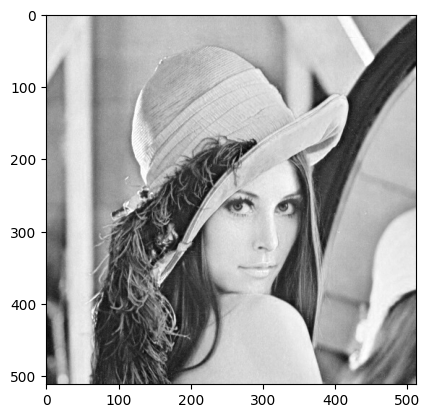

In [ ]:
def take_v_channel_image(hsv_image, output_path):
    height = len(hsv_image)
    width = len(hsv_image[0])
    v_image = Image.new('L', (width, height))  # 'L' mode = grayscale

    for i in range(height):
        for j in range(width):
            v = hsv_image[i][j][2]  # Lấy giá trị V (0.0 - 1.0)
            gray_value = int(v * 255)  # Chuyển về 0 - 255
            v_image.putpixel((j, i), gray_value)

    v_image.save(output_path)

input_image1 = Image.open('images/Lena.jpg')
width, height = input_image1.size
rgb_image = input_image1.convert('RGB')

hsv_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]
for i in range(height):
        for j in range(width):
            r, g, b = rgb_image.getpixel((j, i))
            h, s, v = rgb_to_hsv(r , g , b )
            hsv_image[i][j] = [h, s, v]

take_v_channel_image(hsv_image, 'v_channel_image.png')
v_image = Image.open('v_channel_image.png')
plt.imshow(v_image,cmap='gray')

### 2. Hàm chuyển HSV2RGB

In [ ]:
def hsv_to_rgb(h, s, v):
    if s == 0.0:
        return v, v, v

    i = int(h * 6.0)
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6

    if i == 0:
        return v, t, p
    elif i == 1:
        return q, v, p
    elif i == 2:
        return p, v, t
    elif i == 3:
        return p, q, v
    elif i == 4:
        return t, p, v
    else : #i == 5:
        return v, p, q

### 3. Hàm phát hiện biên

In [ ]:
def detect_edges(value_channel, threshold):
    height = len(value_channel)
    width = len(value_channel[0])
    edges = [[0] * width for _ in range(height)]
    for i in range(1, height):
        for j in range(1, width):
            if (abs(value_channel[i][j] - value_channel[i - 1][j]) > threshold or
                abs(value_channel[i][j] - value_channel[i][j - 1]) > threshold):
                edges[i][j] = 1
    return edges

![edges_detected0.jpg](attachment:edges_detected0.jpg)  
*Kết quả khi không sử dụng Gaussian Blur*

### 4. Hàm LPF

In [ ]:
def low_pass_filter(edges, neighbor_threshold):
    height = len(edges)
    width = len(edges[0])
    filtered_edges = [[edges[i][j] for j in range(width)] for i in range(height)]
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if edges[i][j] == 1:
                neighbor_count = sum([edges[i + di][j + dj] for di in [-1, 0, 1] for dj in [-1, 0, 1]]) - 1
                if neighbor_count < neighbor_threshold:
                    filtered_edges[i][j] = 0
    return filtered_edges

![LPF.jpg](attachment:LPF.jpg)  
*Kết quả khi không sử dụng Gaussian Blur*

### 5. Hàm tính additive magnitude

In [ ]:
def calculate_additive_magnitude(value_channel):
    flat_values = [v for row in value_channel for v in row]
    max_v = max(flat_values)
    min_v = min(flat_values)
    avg_v = sum(flat_values) / len(flat_values)
    mid_v = (max_v + min_v) / 2.0
    return (max_v / 8.0) * (avg_v/mid_v)

### 6. Hàm làm sắc nét ảnh

In [ ]:
def sharpen_edges(hsv_image, edges, additive_magnitude, scale):
    height = len(hsv_image)
    width = len(hsv_image[0])
    new_hsv_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            new_hsv_image[i][j] = hsv_image[i][j]
            if edges[i][j] == 1:
                local_mean = sum([hsv_image[i + di][j + dj][2] for di in [-1, 0, 1] for dj in [-1, 0, 1]]) / 9.0
                if local_mean > hsv_image[i][j][2]:
                    delta = - scale * additive_magnitude * (hsv_image[i][j][2]/ local_mean)
                else:
                    delta = scale * additive_magnitude * (local_mean/ hsv_image[i][j][2])
                new_hsv_image[i][j][2] += delta
                new_hsv_image[i][j][2] = min(max(new_hsv_image[i][j][2], 0), 1)
    return new_hsv_image

### 7.Hàm Gaussian Blur

In [ ]:
def create_gaussian_kernel(kernel_size, sigma):
    kernel = [[0 for _ in range(kernel_size)] for _ in range(kernel_size)]
    center = kernel_size // 2

    # Normalization factor
    sum_val = 0

    # Calculate Gaussian values
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - center, j - center
            exponent = -(x**2 + y**2) / (2 * sigma**2)
            kernel[i][j] = math.exp(exponent) / (2 * math.pi * sigma**2)
            sum_val += kernel[i][j]

    # Normalize to ensure the kernel sums to 1
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i][j] /= sum_val

    return kernel

def apply_gaussian_blur_to_channel(channel, kernel_size=5, sigma=1.0):
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure kernel size is odd

    height = len(channel)
    width = len(channel[0])

    # Create a new channel of the same size
    blurred_channel = [[0 for _ in range(width)] for _ in range(height)]

    # Create the Gaussian kernel
    kernel = create_gaussian_kernel(kernel_size, sigma)

    padding = kernel_size // 2

    # Apply Gaussian blur
    for i in range(height):
        for j in range(width):
            weighted_sum = 0
            weight_sum = 0

            for ki in range(kernel_size):
                for kj in range(kernel_size):
                    ni = i + (ki - padding)
                    nj = j + (kj - padding)

                    # Handle boundary conditions (mirror padding)
                    if ni < 0: ni = abs(ni)
                    if ni >= height: ni = 2 * height - ni - 2
                    if nj < 0: nj = abs(nj)
                    if nj >= width: nj = 2 * width - nj - 2

                    weight = kernel[ki][kj]
                    weighted_sum += channel[ni][nj] * weight
                    weight_sum += weight

            blurred_channel[i][j] = weighted_sum / weight_sum if weight_sum > 0 else 0

    return blurred_channel

### 8. Hàm xử lí ảnh

In [ ]:
def process_image(input_path, output_path, edge_threshold, neighbor_threshold, scale):
    # Load the input image
    input_image = Image.open(input_path)
    width, height = input_image.size
    rgb_image = input_image.convert('RGB')

    # Convert RGB to HSV
    hsv_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            r, g, b = rgb_image.getpixel((j, i))
            h, s, v = rgb_to_hsv(r , g , b )
            hsv_image[i][j] = [h, s, v]

    # Extract the V channel for edge detection
    value_channel = [[hsv_image[i][j][2] for j in range(width)] for i in range(height)]

    # Apply Gaussian blur to the V channel
    value_channel = apply_gaussian_blur_to_channel(value_channel, 5, 0.5)

    # Save blurred image for reference
    blurred_output = Image.new('RGB', (width, height))
    for i in range(height):
        for j in range(width):
            v = value_channel[i][j]
            r, g, b = hsv_to_rgb(hsv_image[i][j][0], hsv_image[i][j][1], v)
            blurred_output.putpixel((j, i), (int(r * 255), int(g * 255), int(b * 255)))
    blurred_output.save('blurred_image.jpg')

    # Detect edges in the V channel
    edges = detect_edges(value_channel, edge_threshold)

    # Save edge-detected image for reference
    edge_image = Image.new('L', (width, height))
    for i in range(height):
        for j in range(width):
            edge_image.putpixel((j, i), int(edges[i][j] * 255))
    edge_image.save('edges_detected.jpg')

    # Apply low-pass filter to edges
    filtered_edges = low_pass_filter(edges, neighbor_threshold)

    # Save filtered edges for reference
    edge_image = Image.new('L', (width, height))
    for i in range(height):
        for j in range(width):
            edge_image.putpixel((j, i), int(filtered_edges[i][j] * 255))
    edge_image.save('LPF.jpg')

    # Calculate additive magnitude and sharpen edges
    additive_magnitude = calculate_additive_magnitude(value_channel)

    # Apply sharpening to the HSV image
    sharpened_hsv_image = sharpen_edges(hsv_image, filtered_edges, additive_magnitude, scale)

    # Save sharpened image
    output_image = Image.new('RGB', (width, height))
    for i in range(height):
        for j in range(width):
            h, s, v = sharpened_hsv_image[i][j]
            r, g, b = hsv_to_rgb(h, s, v)
            output_image.putpixel((j, i), (int(r * 255), int(g * 255), int(b * 255)))

    output_image.save(output_path)

In [ ]:
def process_image1(input_path, output_path, edge_threshold, neighbor_threshold, scale):
    total_start = time.time()

    # Load the input image
    input_image = Image.open(input_path)
    width, height = input_image.size
    rgb_image = input_image.convert('RGB')

    # Convert RGB to HSV
    start = time.time()
    hsv_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]
    for i in range(height):
        for j in range(width):
            r, g, b = rgb_image.getpixel((j, i))
            h, s, v = rgb_to_hsv(r , g , b )
            hsv_image[i][j] = [h, s, v]
    print(f"RGB to HSV time: {time.time() - start:.4f} seconds")

    # Extract V channel
    value_channel = [[hsv_image[i][j][2] for j in range(width)] for i in range(height)]

    # Apply Gaussian blur
    start = time.time()
    value_channel = apply_gaussian_blur_to_channel(value_channel, 5, 0.5)
    print(f"Gaussian Blur time: {time.time() - start:.4f} seconds")

    # Detect edges
    start = time.time()
    edges = detect_edges(value_channel, edge_threshold)
    print(f"Edge Detection time: {time.time() - start:.4f} seconds")

    # Low-pass filter
    start = time.time()
    filtered_edges = low_pass_filter(edges, neighbor_threshold)
    print(f"Low-pass Filter time: {time.time() - start:.4f} seconds")

    # Calculate additive magnitude
    start = time.time()
    additive_magnitude = calculate_additive_magnitude(value_channel)
    print(f"Additive Magnitude time: {time.time() - start:.4f} seconds")

    # Sharpen edges
    start = time.time()
    sharpened_hsv_image = sharpen_edges(hsv_image, filtered_edges, additive_magnitude, scale)
    print(f"Sharpening time: {time.time() - start:.4f} seconds")

    # Save image
    start = time.time()
    output_image = Image.new('RGB', (width, height))
    for i in range(height):
        for j in range(width):
            h, s, v = sharpened_hsv_image[i][j]
            r, g, b = hsv_to_rgb(h, s, v)
            output_image.putpixel((j, i), (int(r * 255), int(g * 255), int(b * 255)))
    output_image.save(output_path)
    print(f"Saving Image time: {time.time() - start:.4f} seconds")

    print(f"Total processing time: {time.time() - total_start:.4f} seconds")

In [ ]:
process_image1(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=0.5)

RGB to HSV time: 45.8922 seconds
Gaussian Blur time: 93.9409 seconds
Edge Detection time: 3.6702 seconds
Low-pass Filter time: 56.7579 seconds
Additive Magnitude time: 4.0604 seconds
Sharpening time: 56.6595 seconds
Saving Image time: 22.5326 seconds
Total processing time: 287.2733 seconds


### 9. Demo

*Làm sắc nét ảnh với e_th=0.07, LPF_th=2, scale=1.0,kerkernel_size=5, radius=0.5*

In [ ]:
edge_threshold = 0.07
neighbor_threshold = 2
scale = 1.0
input_path = 'images/image4.jpg'
process_image(input_path, output_path, edge_threshold, neighbor_threshold, scale)

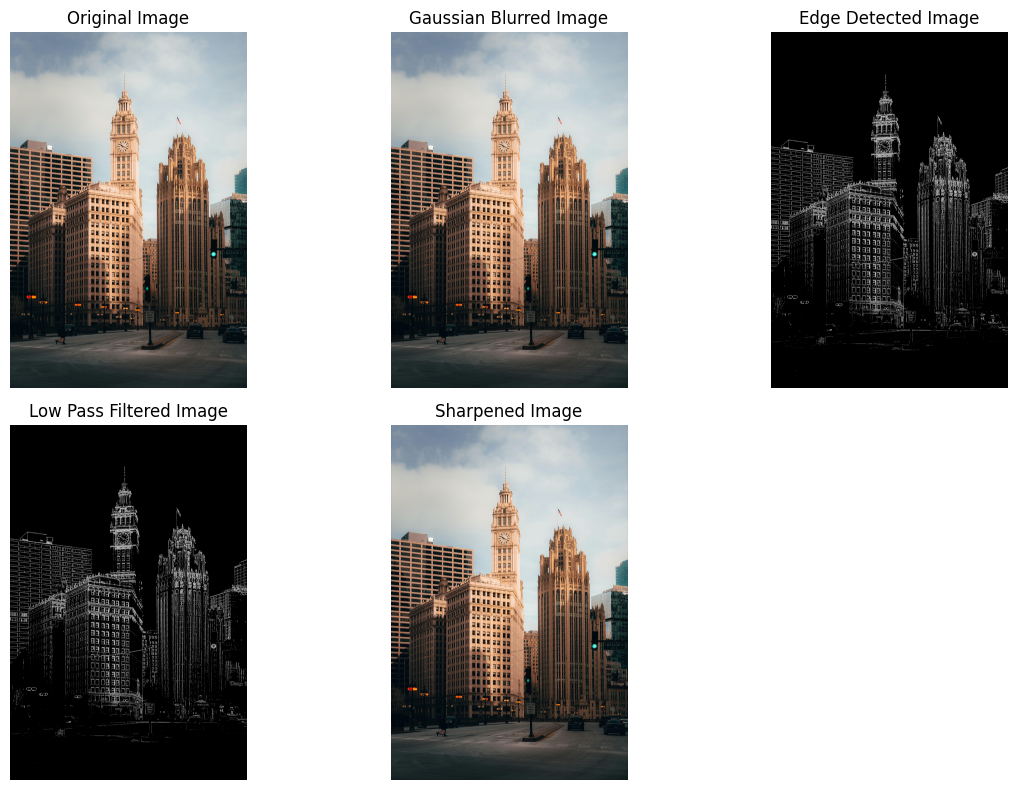

In [ ]:
#Visualize the orginal image, gaussian blurred image, egde detected image, low pass filtered image, sharpened image
def visualize_images(original, blurred, edges, low_pass, sharpened):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title("Gaussian Blurred Image")
    plt.imshow(blurred)
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title("Edge Detected Image")
    plt.imshow(edges,cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title("Low Pass Filtered Image")
    plt.imshow(low_pass,cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title("Sharpened Image")
    plt.imshow(sharpened)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load images
original_image = Image.open(input_path)
gaussian_image = Image.open('blurred_image.jpg')
edges_image = Image.open('edges_detected.jpg')
low_pass_image = Image.open('LPF.jpg')
sharpened_image = Image.open(output_path)

visualize_images(original_image, gaussian_image, edges_image, low_pass_image, sharpened_image)

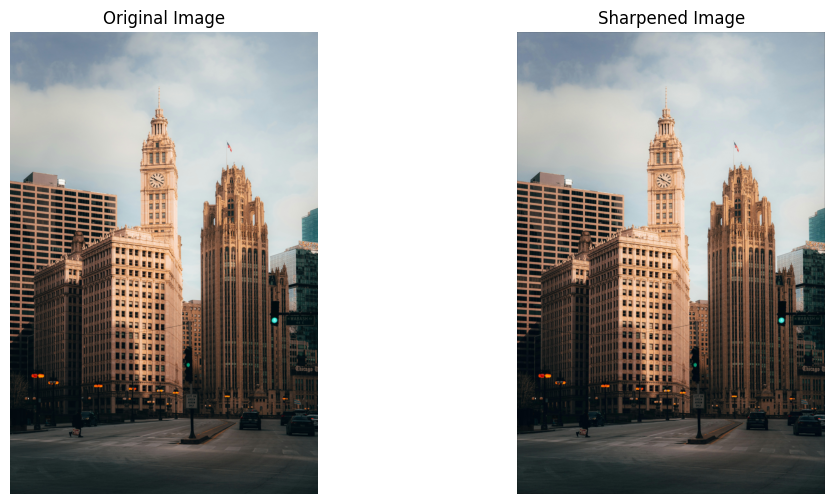

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sharpened Image')
plt.imshow(sharpened_image)
plt.axis('off')

plt.show()

### 10. So sánh với unsharp masking

In [ ]:
original = Image.open('image.jpg').convert('RGB')
original_np = np.array(original)
sharpened = Image.open('sharpened_image.jpg').convert('RGB')
sharpened_np = np.array(sharpened)
diff = np.abs(original_np.astype(int) - sharpened_np.astype(int))
diff = np.clip(diff*10, 0, 255)
diff_image = Image.fromarray(np.uint8(diff))
diff_image.save('difference_image.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'image.jpg'

In [ ]:
def unsharp_masking_pil(input_path, output_path, radius=2, amount=1.5):
    image = Image.open(input_path).convert('RGB')
    blurred = image.filter(ImageFilter.GaussianBlur(radius=radius))
    mask = Image.blend(image, blurred, alpha=-1)
    sharpened = Image.blend(image, mask, alpha=amount)
    sharpened.save(output_path)

unsharp_masking_pil(input_path, 'unsharp_masked_image.jpg', radius=2, amount=1.5)

unsharp_masked_image = Image.open('unsharp_masked_image.jpg')
unsharp_masked_image_np = np.array(unsharp_masked_image)
diff_unsharp = np.abs(original_np.astype(int) - unsharp_masked_image_np.astype(int))
diff_unsharp = np.clip(diff_unsharp*10, 0, 255)
diff_unsharp_image = Image.fromarray(np.uint8(diff_unsharp))
diff_unsharp_image.save('diff_unsharp_masked_image.jpg')

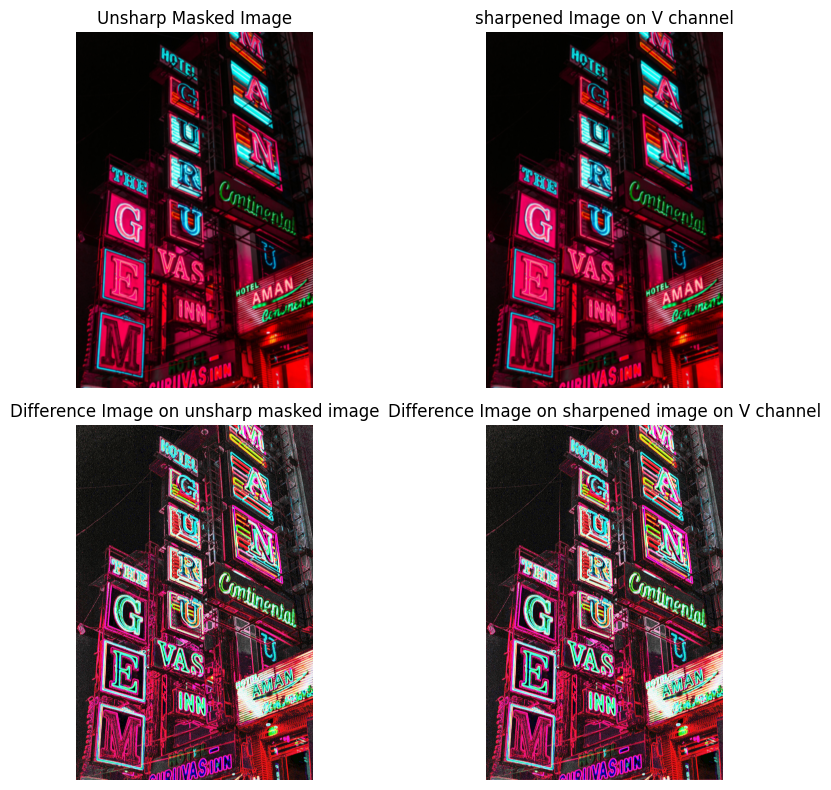

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Unsharp Masked Image')
plt.imshow(unsharp_masked_image)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('sharpened Image on V channel')
plt.imshow(sharpened_image)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Difference Image on unsharp masked image')
plt.imshow(diff_unsharp_image)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Difference Image on sharpened image on V channel')
plt.imshow(diff_image)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_psnr(img1, img2):
    img1 = np.array(img1).astype(np.float32)
    img2 = np.array(img2).astype(np.float32)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # Ảnh giống nhau hoàn toàn

    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr_value = calculate_psnr(original_image, sharpened_image)
print(f"PSNR between original and sharpened image: {psnr_value:.2f} dB")
print(f"PSNR: {psnr_value:.2f} dB")

psnr_value_unsharp = calculate_psnr(original_image, unsharp_masked_image)
print(f"PSNR between original and unsharp masked image: {psnr_value_unsharp:.2f} dB")
print(f"PSNR: {psnr_value_unsharp:.2f} dB")

PSNR between original and sharpened image: 42.81 dB
PSNR: 42.81 dB
PSNR between original and unsharp masked image: 44.72 dB
PSNR: 44.72 dB


* Nhận xét: Phương pháp được sử dụng giữ chi tiết tốt hơn do việc làm sắc nét có chọn lọc khi chỉ thay đổi các pixel ở vùng biên thay vì làm sắc nét có chọn lọc

## IV: Phiên bản tuần tự sử dụng Numba

In [ ]:
@jit(nopython=True, cache=True)
def rgb_to_hsv_numba(r, g, b):
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    maxc = max(r, g, b)
    minc = min(r, g, b)
    v = maxc

    if minc == maxc:
        return 0.0, 0.0, v

    s = (maxc - minc) / maxc
    rc = (maxc - r) / (maxc - minc)
    gc = (maxc - g) / (maxc - minc)
    bc = (maxc - b) / (maxc - minc)

    if r == maxc:
        h = bc - gc
    elif g == maxc:
        h = 2.0 + rc - bc
    else:
        h = 4.0 + gc - rc

    h = (h / 6.0) % 1.0
    return h, s, v


@jit(nopython=True, cache=True)
def hsv_to_rgb_numba(h, s, v):
    if s == 0.0:
        return v, v, v

    i = int(h * 6.0)
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6

    if i == 0:
        return v, t, p
    elif i == 1:
        return q, v, p
    elif i == 2:
        return p, v, t
    elif i == 3:
        return p, q, v
    elif i == 4:
        return t, p, v
    else:  # i == 5
        return v, p, q

@jit(nopython=True, cache=True)
def detect_edges(value_channel, threshold):
    height = len(value_channel)
    width = len(value_channel[0])
    edges = np.zeros((height, width), dtype=np.int32)

    for i in range(1, height):
        for j in range(1, width):
            if (abs(value_channel[i, j] - value_channel[i - 1, j]) > threshold or
                abs(value_channel[i, j] - value_channel[i, j - 1]) > threshold):
                edges[i, j] = 1
    return edges

@jit(nopython=True,cache=True)
def low_pass_filter(edges, neighbor_threshold):
    height = len(edges)
    width = len(edges[0])
    filtered_edges = np.copy(edges)  # Copy edges into filtered_edges

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if edges[i, j] == 1:
                # Count neighbors by checking the 3x3 region around (i, j)
                neighbor_count = np.sum(edges[i - 1:i + 2, j - 1:j + 2]) - 1
                if neighbor_count < neighbor_threshold:
                    filtered_edges[i, j] = 0
    return filtered_edges

@jit(nopython=True,cache=True)
def calculate_additive_magnitude(value_channel):
    # Flatten the 2D list to 1D
    flat_values = [v for row in value_channel for v in row]

    max_v = max(flat_values)
    min_v = min(flat_values)
    avg_v = sum(flat_values) / len(flat_values)
    mid_v = (max_v + min_v) / 2.0

    return (max_v / 8.0) * (avg_v / mid_v)

@jit(nopython=True,cache=True)
def custom_clip(value, min_val, max_val):
    return max(min(value, max_val), min_val)

@jit(nopython=True,cache=True)
def sharpen_edges(hsv_image, edges, additive_magnitude, scale):
    height = len(hsv_image)
    width = len(hsv_image[0])
    new_hsv_image = np.copy(hsv_image)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            new_hsv_image[i][j] = hsv_image[i][j]
            if edges[i][j] == 1:
                local_mean = sum([hsv_image[i + di][j + dj][2] for di in [-1, 0, 1] for dj in [-1, 0, 1]]) / 9.0
                if local_mean > hsv_image[i][j][2]:
                    delta = - scale * additive_magnitude * (hsv_image[i][j][2]/ local_mean)
                else:
                    delta = scale * additive_magnitude * (local_mean/ hsv_image[i][j][2])
                new_hsv_image[i][j][2] += delta
                new_hsv_image[i][j][2] = custom_clip(new_hsv_image[i][j][2], 0, 1)  # Sử dụng hàm custom_clip
    return new_hsv_image

@jit(nopython=True,cache=True)
def create_gaussian_kernel(kernel_size, sigma):
    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = ax[i]
            y = ax[j]
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2. * sigma**2))

    kernel /= np.sum(kernel)
    return kernel

@jit(nopython=True,cache=True)
def apply_gaussian_blur_to_channel(channel, kernel_size=5, sigma=1.0):
    if kernel_size % 2 == 0:
        kernel_size += 1  # Ensure odd size

    height, width = channel.shape
    kernel = create_gaussian_kernel(kernel_size, sigma)
    pad = kernel_size // 2

    # Mirror padding manually
    padded_channel = np.zeros((height + 2 * pad, width + 2 * pad), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            padded_channel[i + pad, j + pad] = channel[i, j]

    # Prepare output
    blurred_channel = np.zeros_like(channel)

    # Convolve manually
    for i in range(height):
        for j in range(width):
            region = padded_channel[i:i + kernel_size, j:j + kernel_size]
            blurred_channel[i, j] = np.sum(region * kernel)

    return blurred_channel

In [ ]:
@njit
def create_gaussian_kernel(kernel_size, sigma):
    half_size = kernel_size // 2
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)

    sum_val = 0.0
    for i in range(-half_size, half_size + 1):
        for j in range(-half_size, half_size + 1):
            val = np.exp(-(i**2 + j**2) / (2 * sigma**2))
            kernel[i + half_size, j + half_size] = val
            sum_val += val

    # Chuẩn hóa
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] /= sum_val

    return kernel

@njit(parallel=True)
def apply_gaussian_blur_to_channel(channel, kernel_size=5, sigma=1.0):
    if kernel_size % 2 == 0:
        kernel_size += 1

    height, width = channel.shape
    kernel = create_gaussian_kernel(kernel_size, sigma)
    pad = kernel_size // 2

    # Reflect padding manually
    padded_height = height + 2 * pad
    padded_width = width + 2 * pad
    padded = np.zeros((padded_height, padded_width), dtype=np.float32)

    for i in range(padded_height):
        for j in range(padded_width):
            ii = min(height - 1, max(0, i - pad))
            jj = min(width - 1, max(0, j - pad))
            padded[i, j] = channel[ii, jj]

    blurred = np.zeros_like(channel)
    for i in prange(height):
        for j in prange(width):
            sum_val = 0.0
            for ki in range(kernel_size):
                for kj in range(kernel_size):
                    sum_val += padded[i + ki, j + kj] * kernel[ki, kj]
            blurred[i, j] = sum_val

    return blurred

In [ ]:
@jit(nopython=True, cache=True)
def rgb_image_to_hsv_batch(image):
    height, width, _ = image.shape
    hsv_image = np.zeros((height, width, 3), dtype=np.float32)
    for i in prange(height):
        for j in range(width):
            r, g, b = image[i, j]
            h, s, v = rgb_to_hsv_numba(r, g, b)
            hsv_image[i, j] = (h, s, v)
    return hsv_image

@jit(nopython=True, cache=True)
def hsv_image_to_rgb_batch(hsv_image):
    height, width, _ = hsv_image.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.float32)
    for i in prange(height):
        for j in range(width):
            h, s, v = hsv_image[i, j]
            r, g, b = hsv_to_rgb_numba(h, s, v)
            rgb_image[i, j] = (r, g, b)
    return rgb_image

In [ ]:
def process_image2(input_path, output_path, edge_threshold, neighbor_threshold, scale):
    total_start = time.time()

    # Load image
    input_image = Image.open(input_path).convert('RGB')
    rgb_array = np.array(input_image, dtype=np.float32)

    # Convert RGB to HSV
    start = time.time()
    hsv_image = rgb_image_to_hsv_batch(rgb_array)
    print(f"RGB to HSV time: {time.time() - start:.4f} seconds")

    # Detect chanel V from HSV
    value_channel = hsv_image[:, :, 2]

    # Apply Gaussian blur to V channel
    start = time.time()
    blurred_v = apply_gaussian_blur_to_channel(value_channel, kernel_size=5, sigma=0.5)
    print(f"Gaussian Blur time: {time.time() - start:.4f} seconds")

    # Detect edges
    start = time.time()
    edges = detect_edges(blurred_v, edge_threshold)
    print(f"Edge Detection time: {time.time() - start:.4f} seconds")

    # Apply low-pass filter to edges
    start = time.time()
    filtered_edges = low_pass_filter(edges, neighbor_threshold)
    print(f"Low-pass Filter time: {time.time() - start:.4f} seconds")

    # Calculate additive magnitude
    start = time.time()
    additive_magnitude = calculate_additive_magnitude(blurred_v)
    print(f"Additive Magnitude time: {time.time() - start:.4f} seconds")

    # Sharpen edges
    start = time.time()
    sharpened_hsv = sharpen_edges(hsv_image, filtered_edges, additive_magnitude, scale)
    print(f"Sharpening time: {time.time() - start:.4f} seconds")

    # Convert HSV back to RGB
    start = time.time()
    output_rgb = hsv_image_to_rgb_batch(np.array(sharpened_hsv))
    output_rgb = np.clip(output_rgb * 255.0, 0, 255).astype(np.uint8)
    print(f"HSV to RGB time: {time.time() - start:.4f} seconds")

    # Save output image
    output_image = Image.fromarray(output_rgb, 'RGB')
    output_image.save(output_path)
    print(f"Total processing time: {time.time() - total_start:.4f} seconds")

In [ ]:
input_path = 'images/image1.jpg' # 4000x6000 pixel
output_path = 'outputs/sharpened_image1.jpg' # 4000x6000 pixel
process_image2(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=0.5)

RGB to HSV time: 0.4751 seconds
Gaussian Blur time: 3.3376 seconds
Edge Detection time: 0.1150 seconds
Low-pass Filter time: 0.0719 seconds
Additive Magnitude time: 0.3143 seconds
Sharpening time: 0.5250 seconds
HSV to RGB time: 0.6474 seconds
Total processing time: 6.0488 seconds


In [ ]:
input_path = 'images/image2.jpg' # 6124x4816 pixel
output_path = 'outputs/sharpened_image2.jpg'
process_image2(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=0.5)

RGB to HSV time: 0.4075 seconds
Gaussian Blur time: 0.2782 seconds
Edge Detection time: 0.0992 seconds
Low-pass Filter time: 0.0785 seconds
Additive Magnitude time: 0.3607 seconds
Sharpening time: 0.6228 seconds
HSV to RGB time: 0.8205 seconds
Total processing time: 3.3862 seconds


In [ ]:
input_path = 'images/image4.jpg' # 6124x4816 pixel
output_path = 'outputs/sharpened_image4.jpg'
process_image2(input_path, output_path, edge_threshold=0.07, neighbor_threshold=2, scale=1)

RGB to HSV time: 0.3397 seconds
Gaussian Blur time: 0.2161 seconds
Edge Detection time: 0.0581 seconds
Low-pass Filter time: 0.0671 seconds
Additive Magnitude time: 0.2844 seconds
Sharpening time: 1.2308 seconds
HSV to RGB time: 0.3260 seconds
Total processing time: 4.5717 seconds


In [ ]:
def process_image2(input_path, output_path, edge_threshold, neighbor_threshold, scale):
    total_start = time.time()

    # Load image
    input_image = Image.open(input_path).convert('RGB')
    rgb_array = np.array(input_image, dtype=np.float32)  # Normalize

    # Convert RGB to HSV
    start = time.time()
    hsv_image = rgb_image_to_hsv_batch(rgb_array)
    print(f"RGB to HSV time: {time.time() - start:.4f} seconds")

    # Save HSV (visualize as RGB for debugging)
    hsv_rgb_preview = hsv_image_to_rgb_batch(hsv_image)
    Image.fromarray((hsv_rgb_preview * 255).astype(np.uint8)).save("step1_hsv_preview.jpg")

    # Detect channel V from HSV
    value_channel = hsv_image[:, :, 2]

    # Apply Gaussian blur to V channel
    start = time.time()
    blurred_v = apply_gaussian_blur_to_channel(value_channel, kernel_size=5, sigma=0.5)
    print(f"Gaussian Blur time: {time.time() - start:.4f} seconds")
    Image.fromarray((blurred_v * 255).astype(np.uint8)).save("step2_blurred_v.jpg")

    # Detect edges
    start = time.time()
    edges = detect_edges(blurred_v, edge_threshold)
    print(f"Edge Detection time: {time.time() - start:.4f} seconds")
    Image.fromarray((edges * 255).astype(np.uint8)).save("step3_edges.jpg")

    # Apply low-pass filter to edges
    start = time.time()
    filtered_edges = low_pass_filter(edges, neighbor_threshold)
    print(f"Low-pass Filter time: {time.time() - start:.4f} seconds")
    Image.fromarray((filtered_edges * 255).astype(np.uint8)).save("step4_filtered_edges.jpg")

    # Calculate additive magnitude
    start = time.time()
    additive_magnitude = calculate_additive_magnitude(blurred_v)
    print(f"Additive Magnitude time: {time.time() - start:.4f} seconds")

    # Sharpen edges
    start = time.time()
    sharpened_hsv = sharpen_edges(hsv_image, filtered_edges, additive_magnitude, scale)
    print(f"Sharpening time: {time.time() - start:.4f} seconds")

    # Save HSV after sharpening
    sharpened_hsv_rgb = hsv_image_to_rgb_batch(sharpened_hsv)
    Image.fromarray((sharpened_hsv_rgb * 255).astype(np.uint8)).save("step5_sharpened_hsv.jpg")

    # Convert HSV back to RGB
    start = time.time()
    output_rgb = np.clip(sharpened_hsv_rgb * 255.0, 0, 255).astype(np.uint8)
    print(f"HSV to RGB time: {time.time() - start:.4f} seconds")

    # Save output image
    output_image = Image.fromarray(output_rgb, 'RGB')
    output_image.save(output_path)
    print(f"Total processing time: {time.time() - total_start:.4f} seconds")


In [ ]:
process_image2(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=1.0)

RGB to HSV time: 0.3458 seconds
Gaussian Blur time: 0.1762 seconds
Edge Detection time: 0.0714 seconds
Low-pass Filter time: 0.0640 seconds
Additive Magnitude time: 0.2768 seconds
Sharpening time: 0.5696 seconds
HSV to RGB time: 0.3736 seconds
Total processing time: 4.0067 seconds


## V.Phiên bản song song 1

In [7]:
!uv pip install -q --system numba-cuda==0.4.0

In [47]:
%%writefile parallel1.py
import cv2
import math
import numpy as np
from numba import cuda
from numba import config
import time
config.CUDA_ENABLE_PYNVJITLINK = 1
from PIL import Image

@cuda.jit
def rgb_to_hsv_kernel(rgb_image, hsv_image):
    i, j = cuda.grid(2)
    if i < rgb_image.shape[0] and j < rgb_image.shape[1]:
        r = rgb_image[i, j, 2]
        g = rgb_image[i, j, 1]
        b = rgb_image[i, j, 0]

        maxc = max(r, g, b)
        minc = min(r, g, b)
        v = maxc

        if minc == maxc:
            h = 0.0
            s = 0.0
        else:
            s = (maxc - minc) / maxc
            rc = (maxc - r) / (maxc - minc)
            gc = (maxc - g) / (maxc - minc)
            bc = (maxc - b) / (maxc - minc)

            if r == maxc:
                h = bc - gc
            elif g == maxc:
                h = 2.0 + rc - bc
            else:
                h = 4.0 + gc - rc

            h = (h / 6.0) % 1.0

        hsv_image[i, j, 0] = h
        hsv_image[i, j, 1] = s
        hsv_image[i, j, 2] = v

def create_gaussian_kernel(kernel_size, sigma):
    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

@cuda.jit
def apply_gaussian_blur_to_channel_kernel(channel, kernel, result, kernel_size):
    i, j = cuda.grid(2)
    if i < channel.shape[0] and j < channel.shape[1]:
        pad = kernel_size // 2
        value = 0.0
        for ki in range(-pad, pad + 1):
            for kj in range(-pad, pad + 1):
                ni = min(max(i + ki, 0), channel.shape[0] - 1)
                nj = min(max(j + kj, 0), channel.shape[1] - 1)
                value += channel[ni, nj] * kernel[ki + pad, kj + pad]
        result[i, j] = value

@cuda.jit
def detect_edges_kernel(channel, edges, threshold):
    i, j = cuda.grid(2)
    if 1 <= i < channel.shape[0] and 1 <= j < channel.shape[1]:
        if (abs(channel[i, j] - channel[i-1, j]) > threshold) or (abs(channel[i, j] - channel[i, j-1]) > threshold):
            edges[i, j] = 1

@cuda.jit
def low_pass_filter_kernel(edges, filtered_edges, neighbor_threshold):
    i, j = cuda.grid(2)
    if 1 <= i < edges.shape[0]-1 and 1 <= j < edges.shape[1]-1:
        if edges[i, j] == 1:
            neighbor_count = 0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    if not (di == 0 and dj == 0):
                        neighbor_count += edges[i+di, j+dj]
            if neighbor_count < neighbor_threshold:
                filtered_edges[i, j] = 0
            else:
                filtered_edges[i, j] = 1

@cuda.jit
def calculate_additive_magnitude_kernel(value_channel, result):
    if cuda.threadIdx.x == 0 and cuda.blockIdx.x == 0:
        flat_values = value_channel.reshape(-1)
        max_v = 0.0
        min_v = 1.0
        sum_v = 0.0
        for i in range(flat_values.shape[0]):
            val = flat_values[i]
            max_v = max(max_v, val)
            min_v = min(min_v, val)
            sum_v += val
        avg_v = sum_v / flat_values.shape[0]
        mid_v = (max_v + min_v) / 2.0
        result[0] = (max_v / 8.0) * (avg_v / mid_v)

@cuda.jit
def sharpen_edges_kernel(hsv_image, edges, additive_magnitude, scale, output_hsv):
    i, j = cuda.grid(2)
    if 1 <= i < hsv_image.shape[0]-1 and 1 <= j < hsv_image.shape[1]-1:
        output_hsv[i, j, 0] = hsv_image[i, j, 0]
        output_hsv[i, j, 1] = hsv_image[i, j, 1]
        output_hsv[i, j, 2] = hsv_image[i, j, 2]
        if edges[i, j] == 1:
            local_sum = 0.0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    local_sum += hsv_image[i+di, j+dj, 2]
            local_mean = local_sum / 9.0
            v = hsv_image[i, j, 2]
            delta = 0
            if local_mean > v:
                delta = -scale * additive_magnitude * (v / local_mean)
            else:
                delta = scale * additive_magnitude * (local_mean / v)
            new_v = v + delta
            output_hsv[i, j, 2] = min(max(new_v, 0.0), 1.0)

@cuda.jit
def hsv_image_to_rgb_batch_kernel(hsv_image, result):
    i, j = cuda.grid(2)
    if i < hsv_image.shape[0] and j < hsv_image.shape[1]:
        h, s, v = hsv_image[i, j, 0], hsv_image[i, j, 1], hsv_image[i, j, 2]
        h = h * 360.0  # Scale to 0-360
        h_i = int(h / 60.0) % 6
        f = (h / 60.0) - h_i
        p = v * (1 - s)
        q = v * (1 - f * s)
        t = v * (1 - (1 - f) * s)

        if h_i == 0:
            r, g, b = v, t, p
        elif h_i == 1:
            r, g, b = q, v, p
        elif h_i == 2:
            r, g, b = p, v, t
        elif h_i == 3:
            r, g, b = p, q, v
        elif h_i == 4:
            r, g, b = t, p, v
        else:  # h_i == 5
            r, g, b = v, p, q

        # OpenCV uses BGR order
        result[i, j, 2] = b * 255.0  # B
        result[i, j, 1] = g * 255.0  # G
        result[i, j, 0] = r * 255.0  # R

# Main GPU processing function

def process_image_on_gpu(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=0.5):
    timings = {}
    start_time = time.time()  # Start time for the entire process
    img = cv2.imread(input_path)
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32) / 255.0
    height, width = hsv_image.shape[:2]
    value_channel = hsv_image[:, :, 2]
    img = cv2.imread(input_path)
    d_rgb_image = cuda.to_device(img.astype(np.float32))
    d_hsv_image = cuda.device_array((img.shape[0], img.shape[1], 3), dtype=np.float32)

    threadsperblock = (16, 16)
    blockspergrid = (
    math.ceil(img.shape[0] / threadsperblock[0]),
    math.ceil(img.shape[1] / threadsperblock[1])
    )
    rgb_to_hsv_start= time.time()
    rgb_to_hsv_kernel[blockspergrid, threadsperblock](d_rgb_image, d_hsv_image)
    cuda.synchronize()
    rgb_to_hsv_end = time.time()
    timings['RGB to HSV'] = rgb_to_hsv_end - rgb_to_hsv_start
    # Prepare data
    kernel_size = 5
    sigma = 1.0
    kernel = create_gaussian_kernel(kernel_size, sigma)

    d_value_channel = cuda.to_device(np.ascontiguousarray(value_channel))
    d_blurred_channel = cuda.device_array_like(value_channel)
    d_edges = cuda.device_array(value_channel.shape, dtype=np.int32)
    d_filtered_edges = cuda.device_array(value_channel.shape, dtype=np.int32)
    d_hsv_image = cuda.to_device(hsv_image)
    d_output_hsv = cuda.device_array_like(hsv_image)
    d_rgb_image = cuda.device_array_like(img)
    d_kernel = cuda.to_device(kernel)
    d_additive_magnitude = cuda.device_array(1, dtype=np.float32)

    threadsperblock = (16, 16)
    blockspergrid = (
        math.ceil(height / threadsperblock[0]),
        math.ceil(width / threadsperblock[1])
    )

    # Gaussian Blur
    blur_start = time.time()  # Start time for Gaussian blur
    apply_gaussian_blur_to_channel_kernel[blockspergrid, threadsperblock](d_value_channel, d_kernel, d_blurred_channel, kernel_size)
    cuda.synchronize()
    blur_end = time.time()  # End time for Gaussian blur
    timings['Gaussian Blur'] = blur_end - blur_start

    # Edge Detection
    edge_start = time.time()  # Start time for edge detection
    detect_edges_kernel[blockspergrid, threadsperblock](d_blurred_channel, d_edges, edge_threshold)
    cuda.synchronize()
    edge_end = time.time()  # End time for edge detection
    timings['Edge Detection'] = edge_end - edge_start

    # Edge Filtering
    filter_start = time.time()  # Start time for edge filtering
    low_pass_filter_kernel[blockspergrid, threadsperblock](d_edges, d_filtered_edges, neighbor_threshold)
    cuda.synchronize()
    filter_end = time.time()  # End time for edge filtering
    timings['Edge Filtering'] = filter_end - filter_start

    # Additive Magnitude
    additive_start = time.time()  # Start time for additive magnitude calculation
    calculate_additive_magnitude_kernel[1, 1](d_value_channel, d_additive_magnitude)
    cuda.synchronize()
    additive_end = time.time()  # End time for additive magnitude calculation
    timings['Additive Magnitude'] = additive_end - additive_start

    # Sharpen Edges
    sharpen_start = time.time()  # Start time for sharpening edges
    sharpen_edges_kernel[blockspergrid, threadsperblock](d_hsv_image, d_filtered_edges, d_additive_magnitude[0], scale, d_output_hsv)
    cuda.synchronize()
    sharpen_end = time.time()  # End time for sharpening edges
    timings['Sharpen Edges'] = sharpen_end - sharpen_start

    # HSV to RGB
    hsv2rgb_start = time.time()  # Start time for HSV to RGB conversion
    hsv_image_to_rgb_batch_kernel[blockspergrid, threadsperblock](d_output_hsv, d_rgb_image)
    cuda.synchronize()
    hsv2rgb_end = time.time()  # End time for HSV to RGB conversion
    timings['HSV to RGB'] = hsv2rgb_end - hsv2rgb_start

    output_rgb = d_rgb_image.copy_to_host().astype(np.uint8)
    cv2.imwrite(output_path, output_rgb)

    end_time = time.time()  # End time for the entire process
    total_time = end_time - start_time
    print("Processing completed in {:.4f} seconds.".format(total_time))

    # Print the time taken for each step
    for step, duration in timings.items():
        print(f"{step} : {duration:.4f} seconds")

input_path = 'image1.jpg'  # 4000x6000 pixel
output_path = 'sharpened_image1_gpu.jpg'  # 4000x6000 pixel
process_image_on_gpu(input_path, output_path, edge_threshold=0.1, neighbor_threshold=2, scale=0.5)


Overwriting parallel1.py


In [48]:
!python parallel1.py

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
Processing completed in 5.6676 seconds.
RGB to HSV : 0.2760 seconds
Gaussian Blur : 0.1507 seconds
Edge Detection : 0.0746 seconds
Edge Filtering : 0.1157 seconds
Additive Magnitude : 3.3233 seconds
Sharpen Edges : 0.1489 seconds
HSV to RGB : 0.1104 seconds


In [49]:
!python parallel1.py

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
Processing completed in 5.7058 seconds.
RGB to HSV : 0.2787 seconds
Gaussian Blur : 0.1516 seconds
Edge Detection : 0.0922 seconds
Edge Filtering : 0.1134 seconds
Additive Magnitude : 3.3180 seconds
Sharpen Edges : 0.1492 seconds
HSV to RGB : 0.1134 seconds


| Bước xử lý             | CPU  | CPU (OpenCV + NumPy) |  CPU (OpenCV + NumPy + CPU parallel) |  GPU CUDA v1 (baseline) |
|------------------------|-----------------------|--------------------------|------------------------------------|----------------------------------|
| RGB to HSV             | 45.89 s | 0.47 s | | 0.28 s |
| Gaussian Blur          | 93.94 s   | 3.33 s| 0.15 s| 0.48 s|
| Edge Detection         | 3.67 s| 0.12 s| 0.33 s| 0.09 s|
| Edge Filtering         | 56.76 s| 0.07 s| 0.29 s| 0.11 s|
| Additive Magnitude     | 4.06 s| 0.31 s| 0.12 s| 3.32 s|
| Sharpen Edges          | 56.66 s| 0.53 s| 0.34 s| 0.15 s|
| HSV → RGB              | 22.53 s| 0.65 s| 0.22 s| 0.11 s|
| **Tổng thời gian**     | **287.27**| **6.05 s**| **1.91 s**| **5.71 s**|
